## VAE : Variational Auto Encoder

# Preparation

## Preparation of google drive (if required)

In [1]:
#　colaboratory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch220301/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220301/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [4]:
!pip install lark-parser

     |████████████████████████████████| 103 kB 5.9 MB/s 


In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

## サンプルデータの生成

In [6]:
import torch.utils as utils
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(x_train.shape)

torch.Size([1797, 64])


## サンプルデータの図化

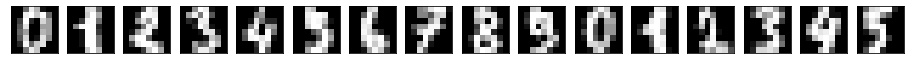

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

## ニューラルネットワークの定義

In [8]:
import torch.distributions as td

class VAE(torch.nn.Module):
  
  class Net(torch.nn.Module):
    def __init__( self, n_in, n_mid, n_out, n_z ):
      super().__init__()
      print("create net class")
      self.fc1 = nn.Linear(n_in, n_mid)
      self.bn1 = nn.BatchNorm1d(n_mid)
      self.fc2_mean = nn.Linear(n_mid, n_z)
      self.fc2_var  = nn.Linear(n_mid, n_z)
      self.fc3 = nn.Linear(n_z  ,n_mid)
      self.fc4 = nn.Linear(n_mid,n_out)
      #self.drop1 = nn.Dropout(p=0.2)
    
      nn.init.constant_(self.fc1.bias,0)
      nn.init.constant_(self.fc2_mean.bias,0)
      nn.init.constant_(self.fc2_var.bias,0)
      nn.init.constant_(self.fc3.bias,0)
      nn.init.constant_(self.fc4.bias,0)
    
    def forward( self, x ):
      # encoder
      self.x1 = F.relu( self.fc1(x) )
      self.x2 = self.bn1( self.x1 )
      m1 = self.fc2_mean( self.x2 )
      v1 = self.fc2_var( self.x2 )
      self.mean = m1;
      self.log_var = v1;

      # reparametrization
      self.std = torch.exp( 0.5 * self.log_var )
      q_z = td.normal.Normal( self.mean, self.std )
      self.z = q_z.rsample()

      # decoder
      y = F.relu( self.fc3( self.z ) )
      #y = self.drop1( y )
      y = torch.sigmoid( self.fc4( y ) )
      self.out = y 

      return y, q_z
  
  class Loss(torch.nn.Module):
    def __init__(self):
      super().__init__()
      print("create loss class")

    def forward( self, y, x, q_z ):
      e1 = F.binary_cross_entropy( y , x, reduction="sum" )
      p_z = td.normal.Normal( torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale) )
      e2  = td.kl_divergence( q_z, p_z ).sum()

      self.loss1 = e1
      self.loss2 = e2
      #print("e1,e2",e1,e2)
      return (e1+e2)

  def __init__( self, n_in, n_mid, n_out, n_z ):
    super( VAE, self ).__init__()
    print("create vae class")
    self.net  = self.Net( n_in, n_mid, n_out, n_z )
    self.loss = self.Loss()

  def forward( self, x ):
    y, q_z = self.net(x)
    output = self.loss( y, x, q_z )
    return output


## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'vae'
folder = './vae'
json_path = folder + '/' + project +'.json'

In [10]:
! mkdir -p vae

## 計算グラフをJSONファイルに変換する

In [11]:
def generate_json( json_path, input ):
    model = VAE( n_in, n_mid, n_out, n_z )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [12]:
torch.manual_seed( 1 )

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#x.requires_grad = True

model = generate_json( json_path, x )

create vae class
create net class
create loss class
[SAVE] ./vae/vae.json
skip: VAE/Net[net]/Linear[fc1]/weight/fc1
skip: VAE/Net[net]/Linear[fc1]/weight/fc1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/BatchNorm1d[bn1]/weight/bn1
skip: VAE/Net[net]/Linear[fc2_mean]/weight/fc2_mean
skip: VAE/Net[net]/Linear[fc2_mean]/weight/fc2_mean
skip: VAE/Net[net]/Linear[fc2_var]/weight/fc2_var
skip: VAE/Net[net]/Linear[fc2_var]/weight/fc2_var
skip: VAE/Net[net]/Linear[fc3]/weight/fc3
skip: VAE/Net[net]/Linear[fc3]/weight/fc3
skip: VAE/Net[net]/Linear[fc4]/weight/fc4
skip: VAE/Net[net]/Linear[fc4]/weight/fc4


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 0.4703369140625 (up to 1e-05 allowed)
Relative difference: 0.0003294008981624594 (up to 1e-05 allowed)
  _module_class,


C++コードを生成する

In [13]:
minictorch.convert_all( project, folder, model, json_path, x, {"input_data":dd}, sol="vae", epochs=200, batch=32, lr=0.001, z="fc3", shuffle=1 )

[JSON] ./vae/vae.json
param: xin  - str loop  255  /  255
{'name': 'VAE/Net[net]/Linear[fc1]/weight/weight.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
param: fc1_weight  - str loop  127  /  127
{'name': 'VAE/Net[net]/Linear[fc1]/bias/bias.13', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
param: fc1_bias  - str loop  1  /  1
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/weight/weight.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 5}
param: bn1_weight  - str loop  1  /  1
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/bias/bias.15', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 6}
param: bn1_bias  - str loop  1  /  1
{'name': 'VAE/Net[net]/BatchNorm1d[bn1]/running_mean/running_mean', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 7}
param: bn1_running_mean  - str loop  1  /  1
{'

In [14]:
# check code
print(x.shape)
with torch.set_grad_enabled(True):
  model.train()
  output = model( x )
  print("output",output)
  output.backward()
  print("input_grad",x.grad)

torch.Size([32, 64])
output tensor(1448.0217, grad_fn=<AddBackward0>)
input_grad None


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

# コンパイル

In [16]:
C_SRC = './vae/vae.cpp ./vae/vae_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './vae/vae'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./vae/vae.cpp ./vae/vae_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./vae/vae


In [17]:
!./vae/vae

### forward computation ...
{ 1452.403442}
### backward computation ...
input_grad{{-0.125258,  0.182919, -0.01408 , ..., -0.088459, -0.858717,  0.31935 },
 { 0.159821,  0.692014,  0.556623, ..., -0.145081,  0.285678,  0.64644 },
 { 1.913896, -1.648967,  0.047376, ...,  0.648749, -0.584697, -1.671622},
 ..., 
 {-0.253909, -0.497299,  0.239077, ..., -0.459145, -0.707026, -0.537639},
 { 0.39497 , -0.093664, -0.296295, ..., -0.112299, -0.966484,  0.441378},
 { 0.594774, -0.168871, -0.430799, ..., -0.309275,  0.039534, -0.03901 }}


# Python 学習コード

## ミニバッチによる学習の実行(python)

In [18]:
torch.manual_seed( 1 )

epoch_num = 200
batch_size = 32

vae = VAE( n_in, n_mid, n_out, n_z )
vae.train()

lr = 0.001
opt = torch.optim.SGD( vae.parameters(), lr)
#opt = torch.optim.Adam( vae.parameters(), lr )

epoch_loss = []

l_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",l_batch,len(x_train),batch_size)

for i in range(epoch_num):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(l_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        #x_mb.requires_grad = True
        
        # 順伝播と逆伝播
        loss = vae( x_mb )
        total_loss += float(loss);

        opt.zero_grad()
        loss.backward()
        opt.step()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
  
    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )
    #print(x2.shape)

    vae.eval()
    loss = vae( x2 )
    print("loss", loss, vae.loss.loss1, vae.loss.loss2 )
    epoch_loss.append( float(loss) )

create vae class
create net class
create loss class
batch 56 1797 32
EPOCH: 0 loss: 61036.371520996094
loss tensor(51550.1875, grad_fn=<AddBackward0>) tensor(48984.9570, grad_fn=<BinaryCrossEntropyBackward0>) tensor(2565.2314, grad_fn=<SumBackward0>)
EPOCH: 1 loss: 50510.69226074219
loss tensor(49394.2969, grad_fn=<AddBackward0>) tensor(47606.4805, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1787.8180, grad_fn=<SumBackward0>)
EPOCH: 2 loss: 48790.32275390625
loss tensor(48165.2383, grad_fn=<AddBackward0>) tensor(46298.3242, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1866.9137, grad_fn=<SumBackward0>)
EPOCH: 3 loss: 47873.90399169922
loss tensor(47508.5234, grad_fn=<AddBackward0>) tensor(45804.7031, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1703.8217, grad_fn=<SumBackward0>)
EPOCH: 4 loss: 47276.74084472656
loss tensor(47072.7188, grad_fn=<AddBackward0>) tensor(45231.1719, grad_fn=<BinaryCrossEntropyBackward0>) tensor(1841.5477, grad_fn=<SumBackward0>)
EPOCH: 5 loss: 46647.4954

収束状況グラフを描画する

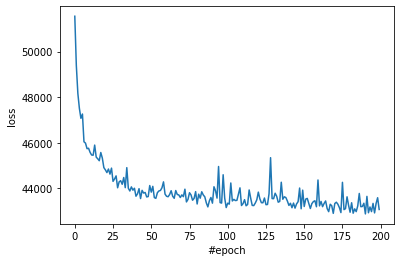

In [19]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

O (1797, 64)


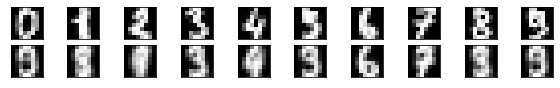

In [20]:
n_img2=10
x2 = x_train.clone().detach()
x3 = x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = vae( x2 )

o = vae.net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

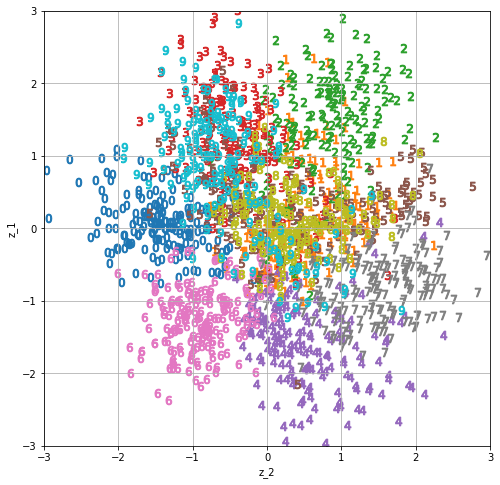

In [21]:
t2 = t_train #[:n_batch]

x2 = x_train.clone().detach()
torch.reshape( x2, (-1,n_in) )
loss = vae( x2 )

plt.figure(figsize=(8,8))
for i in range(10):
  zt = vae.net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

潜在変数を変化させたときの画像を描画する

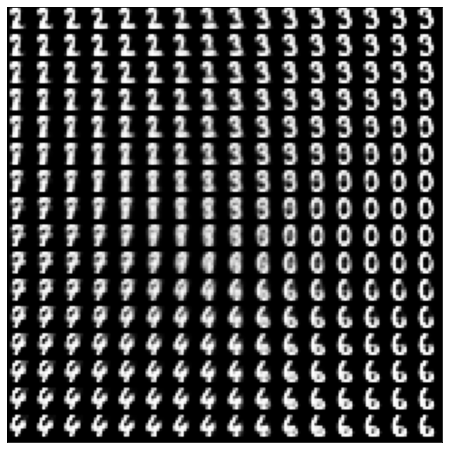

torch.Size([32, 64])


In [22]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( vae.net.fc3(zz) )
      o = torch.sigmoid( vae.net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

print(x.shape)

# C++ 学習コード

学習用のC++コードをコンパイル、リンクする

In [23]:
C_SRC = './vae/vae.cpp ./vae/vae_param.cpp ./vae/vae_data.cpp ./vae/vae_train.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './vae/vae_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./vae/vae.cpp ./vae/vae_param.cpp ./vae/vae_data.cpp ./vae/vae_train.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./vae/vae_train


In [24]:
!./vae/vae_train

epoch_num : 200
batch  number  : 56,32
learning ratio : 0.001
total_loss : epoch 0 - loss 61031.5
epoch 0 - loss 51323.1 ( 48834.2 , 2488.93 ) 
total_loss : epoch 1 - loss 49824.5
epoch 1 - loss 48914.1 ( 46824.1 , 2090 ) 
total_loss : epoch 2 - loss 48394.1
epoch 2 - loss 47776.4 ( 45949.5 , 1826.86 ) 
total_loss : epoch 3 - loss 47589.3
epoch 3 - loss 47229.4 ( 45422.4 , 1806.99 ) 
total_loss : epoch 4 - loss 46846.5
epoch 4 - loss 46397.2 ( 44548.9 , 1848.32 ) 
total_loss : epoch 5 - loss 46293.5
epoch 5 - loss 46044 ( 43661.4 , 2382.65 ) 
total_loss : epoch 6 - loss 46021.1
epoch 6 - loss 45871.3 ( 43403.1 , 2468.26 ) 
total_loss : epoch 7 - loss 45977.6
epoch 7 - loss 45928.1 ( 43389.5 , 2538.69 ) 
total_loss : epoch 8 - loss 45747.4
epoch 8 - loss 45567.7 ( 42973.7 , 2593.93 ) 
total_loss : epoch 9 - loss 45800.2
epoch 9 - loss 45523.3 ( 43034.2 , 2489.07 ) 
total_loss : epoch 10 - loss 45702.4
epoch 10 - loss 45574.4 ( 42863.8 , 2710.53 ) 
total_loss : epoch 11 - loss 45695.2
ep

## C++コード実行結果の出力ファイルを読み込む（Python）


In [25]:
# load out file
path = folder + '/' + project + '.out'
f = open( path, 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  epoch_loss.append( float(data) )
f.close()

print("OUT",path)
print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
path = folder + '/' + project + '.pred'
f2 = open( path, 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

print("PRED",path)

# load z file
path = folder + '/' + project + '.z'
f3 = open( path, 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("Z",path)
print("z =", nz1,nz2 )
#print(z_pred)

OUT ./vae/vae.out
epoch = 200
[51323.125, 48914.117188, 47776.363281, 47229.402344, 46397.167969, 46044.003906, 45871.316406, 45928.148438, 45567.679688, 45523.273438, 45574.378906, 45369.269531, 45403.035156, 45362.753906, 45338.28125, 45242.859375, 45173.472656, 45267.519531, 45013.183594, 45107.484375, 45035.164062, 44958.640625, 44959.371094, 44684.507812, 44727.550781, 44666.375, 44674.054688, 44562.359375, 44612.089844, 44328.253906, 44432.546875, 44396.742188, 44393.925781, 44220.015625, 44235.953125, 44383.738281, 44195.003906, 44259.945312, 44075.390625, 44104.375, 44101.21875, 44221.722656, 44164.207031, 44120.082031, 44275.085938, 44034.210938, 43970.597656, 43992.195312, 43947.867188, 44226.273438, 44124.449219, 44188.414062, 43893.308594, 43982.589844, 43925.722656, 43966.886719, 43793.265625, 43993.0625, 43834.128906, 43791.703125, 43815.097656, 43874.28125, 43589.554688, 43956.007812, 43618.320312, 43692.582031, 43635.394531, 43741.492188, 43560.234375, 43606.25, 43847.9

収束状況グラフを描画する

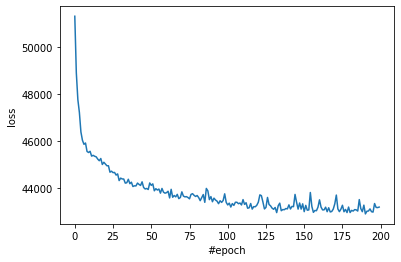

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

生成された画像を描画する

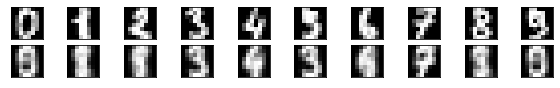

In [27]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

潜在変数の空間を描画する

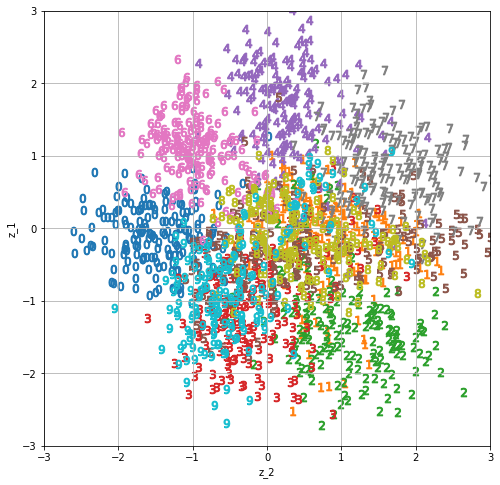

In [28]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()